### Determining the selling price of used cars for auction allows for steady risk and financial management 

In [325]:
 !pip install scikit-learn==0.24.1

In [326]:
import sklearn
sklearn.__version__

'0.24.1'

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

Removing bad rows

In [328]:
car_df = pd.read_csv('car_prices.csv', error_bad_lines=False, engine='python')

Skipping line 187590: ',' expected after '"'
Skipping line 188328: ',' expected after '"'
Skipping line 200738: ',' expected after '"'
Skipping line 200968: ',' expected after '"'
Skipping line 406738: ',' expected after '"'
Skipping line 408158: Expected 16 fields in line 408158, saw 17
Skipping line 417832: Expected 16 fields in line 417832, saw 17
Skipping line 421286: Expected 16 fields in line 421286, saw 17
Skipping line 424158: Expected 16 fields in line 424158, saw 17
Skipping line 427037: Expected 16 fields in line 427037, saw 17
Skipping line 427040: Expected 16 fields in line 427040, saw 17
Skipping line 434421: Expected 16 fields in line 434421, saw 17
Skipping line 444498: Expected 16 fields in line 444498, saw 17
Skipping line 453791: Expected 16 fields in line 453791, saw 17
Skipping line 461594: Expected 16 fields in line 461594, saw 17
Skipping line 461609: Expected 16 fields in line 461609, saw 17
Skipping line 492481: Expected 16 fields in line 492481, saw 17
Skippin

## Understanding the Data

In [329]:
car_df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [330]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558806 entries, 0 to 558805
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558806 non-null  int64  
 1   make          548505 non-null  object 
 2   model         548407 non-null  object 
 3   trim          548155 non-null  object 
 4   body          545611 non-null  object 
 5   transmission  493453 non-null  object 
 6   vin           558806 non-null  object 
 7   state         558806 non-null  object 
 8   condition     547012 non-null  float64
 9   odometer      558712 non-null  float64
 10  color         558057 non-null  object 
 11  interior      558057 non-null  object 
 12  seller        558806 non-null  object 
 13  mmr           558806 non-null  int64  
 14  sellingprice  558806 non-null  int64  
 15  saledate      558806 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


In [331]:
car_df.describe()

,year,condition,odometer,mmr,sellingprice
count,558806.000000,547012.000000,558712.000000,558806.000000,558806.000000
mean,2010.038659,3.424503,68323.586393,13769.284913,13611.174517
std,3.966810,0.949437,53397.831520,9679.905657,9749.618445
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,2.700000,28375.000000,7100.000000,6900.000000
50%,2012.000000,3.600000,52256.500000,12250.000000,12100.000000
75%,2013.000000,4.200000,99113.250000,18300.000000,18200.000000
max,2015.000000,5.000000,999999.000000,182000.000000,230000.000000


In [332]:
car_df.describe(include=['O'])


,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,548505,548407,548155,545611,493453,558806,558806,558057,558057,558806,558806
unique,96,973,1975,86,2,550291,38,20,17,14263,3745
top,Ford,Altima,Base,Sedan,automatic,wbanv13588cz57827,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,93554,19349,55817,199436,475909,5,82945,110970,244323,19693,5334


In [333]:
car_df.nunique()

year                34
make                96
model              973
trim              1975
body                86
transmission         2
vin             550291
state               38
condition           41
odometer        172277
color               20
interior            17
seller           14263
mmr               1101
sellingprice      1887
saledate          3745
dtype: int64

## Cleaning the Data

In [334]:
car_df = car_df.drop_duplicates(subset=['vin'])

In [335]:
# 'vin' is unique so it's not needed but has been used to remove duplicates, 
# 'saledate' is not important for this project but some valuable information can be extracted using time-series analysis
car_df.drop(columns=['vin', 'saledate', 'seller'], axis=1, inplace=True)

In [336]:
car_df.isnull().sum()*100/car_df.isnull().count()

year             0.000000
make             1.836119
model            1.853928
trim             1.899177
body             2.360024
transmission    11.716165
state            0.000000
condition        2.141412
odometer         0.015992
color            0.135201
interior         0.135201
mmr              0.000000
sellingprice     0.000000
dtype: float64

#### Handling Missing Values

I decided to just remove any missing values for simplicity but mean imputations for continuous variables may be better

In [337]:
for blank in car_df.columns:
  car_df[blank] = car_df[blank].replace('', np.nan)



In [338]:
car_df = car_df.dropna()

In [339]:
car_df.isnull().sum()*100/car_df.isnull().count()

year            0.0
make            0.0
model           0.0
trim            0.0
body            0.0
transmission    0.0
state           0.0
condition       0.0
odometer        0.0
color           0.0
interior        0.0
mmr             0.0
sellingprice    0.0
dtype: float64

In [340]:
car_df[['interior', 'color']] = car_df[['interior', 'color']].replace("—", np.nan)

#### Structural Problems: Different Category Error


In [341]:
# remove any categories with less than 100 observations in the df
car_df = car_df.groupby('make').filter(lambda x : len(x)>100)
car_df = car_df.groupby('model').filter(lambda x : len(x)>100)
car_df = car_df.groupby('interior').filter(lambda x : len(x)>100)
car_df = car_df.groupby('color').filter(lambda x : len(x)>100)
car_df = car_df.groupby('body').filter(lambda x : len(x)>100)
car_df = car_df.groupby('trim').filter(lambda x : len(x)>100)
car_df = car_df.groupby('state').filter(lambda x : len(x)>100)

#### Text Errors

In [342]:
# removes any categorical errors by capitalizing the first letter only
car_df['body'] = car_df['body'].apply(lambda x: x.capitalize())
car_df['state'] = car_df['state'].apply(lambda x: x.upper())
car_df['trim'] = car_df['trim'].apply(lambda x: x.upper())

In [343]:
car_df.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice
0,2015,Kia,Sorento,LX,Suv,automatic,CA,5.0,16639.0,white,black,20500,21500
1,2015,Kia,Sorento,LX,Suv,automatic,CA,5.0,9393.0,white,beige,20800,21500
3,2015,Volvo,S60,T5,Sedan,automatic,CA,4.1,14282.0,white,black,27500,27750
5,2015,Nissan,Altima,2.5 S,Sedan,automatic,CA,1.0,5554.0,gray,black,15350,10900
7,2014,Chevrolet,Cruze,1LT,Sedan,automatic,CA,2.0,28617.0,black,black,11900,9800


### Outliers

Continuous Variables at focus: odometer, mmr, sellingprice

Outliers affect the average (median/mean) therefore it's important that we remove them.



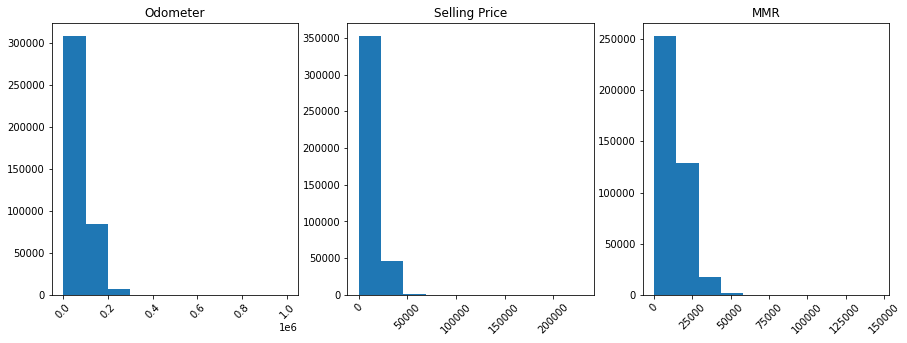

In [344]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#fig.tight_layout(pad=3)

ax[0].hist(car_df['odometer'])
ax[0].set_title('Odometer')
ax[0].tick_params(axis='x', rotation=45)

ax[1].hist(car_df['sellingprice'])
ax[1].set_title('Selling Price')
ax[1].tick_params(axis='x', rotation=45)

ax[2].hist(car_df['mmr'])
ax[2].set_title('MMR')
ax[2].tick_params(axis='x', rotation=45)

We see that these variables have a right skew

In [345]:
print(stats.describe(car_df['odometer']))
print(stats.describe(car_df['sellingprice']))
print(stats.describe(car_df['mmr']))

DescribeResult(nobs=400823, minmax=(1.0, 999999.0), mean=66409.77875022142, variance=2635762590.4620185, skewness=1.956470968915975, kurtosis=15.825179117105758)
DescribeResult(nobs=400823, minmax=(1, 230000), mean=13328.628342185952, variance=74377315.74222349, skewness=1.327993180787359, kurtosis=5.140559120467861)
DescribeResult(nobs=400823, minmax=(25, 146000), mean=13478.07136816001, variance=72630996.41995811, skewness=1.3183153293615317, kurtosis=4.291288945865258)


#### Handling Outliers

In [346]:
car_df = car_df[car_df['odometer'] < 300000]

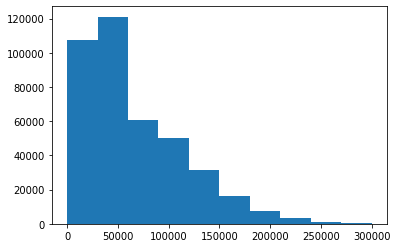

In [347]:
plt.hist(car_df['odometer'])
plt.show()

I removed any rows which had 300K+ values or more.

In [348]:
car_df = car_df[car_df['sellingprice'] < 100000]

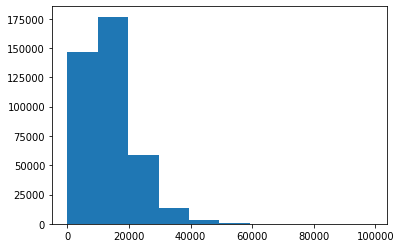

In [349]:
plt.hist(car_df['sellingprice'])
plt.show()

As with the odometer, I removed any rows which had 100k values or more.

### Group: Make & Model

To get rid of random combination between make and model, I combine these two variables.

In [350]:
car_df['make_model'] = car_df['make'] + ' ' + car_df['model']

In [351]:
car_df.drop(columns=['make', 'model'], inplace=True)

In [352]:
car_df = car_df.groupby('make_model').filter(lambda x : len(x)>1000)

In [353]:
for blank in car_df.columns:
  car_df[blank] = car_df[blank].replace('', np.nan)

## Exploratory Data Analysis

#### Univariate Analysis

The number of rows has now dwindled since I first loaded in the raw data

In [354]:
car_df.shape

(310116, 12)

#### Descriptive Stats

In [355]:
car_df.describe()

,year,condition,odometer,mmr,sellingprice
count,310116.000000,310116.000000,310116.000000,310116.000000,310116.000000
mean,2010.688294,3.457112,62732.602500,13357.086300,13204.851146
std,3.475487,0.924978,47972.784634,7616.119083,7730.320577
min,1990.000000,1.000000,1.000000,25.000000,1.000000
25%,2009.000000,2.800000,27598.000000,8300.000000,8000.000000
50%,2012.000000,3.600000,47126.500000,12300.000000,12200.000000
75%,2013.000000,4.200000,88728.000000,17300.000000,17200.000000
max,2015.000000,5.000000,299999.000000,72000.000000,79000.000000


In [356]:
car_df.describe(include=['O'])

,trim,body,transmission,state,color,interior,make_model
count,310116,310116,310116,310116,310116,310116,310116
unique,249,17,2,32,17,15,100
top,SE,Sedan,automatic,FL,black,black,Nissan Altima
freq,31244,155878,302090,48348,63791,144096,14912


The trim may have too many categories, so we need to decide whether to drop it or not later

In [357]:
car_df.head()

,year,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,make_model
0,2015,LX,Suv,automatic,CA,5.0,16639.0,white,black,20500,21500,Kia Sorento
1,2015,LX,Suv,automatic,CA,5.0,9393.0,white,beige,20800,21500,Kia Sorento
5,2015,2.5 S,Sedan,automatic,CA,1.0,5554.0,gray,black,15350,10900,Nissan Altima
7,2014,1LT,Sedan,automatic,CA,2.0,28617.0,black,black,11900,9800,Chevrolet Cruze
8,2014,2.0T PREMIUM PLUS QUATTRO,Sedan,automatic,CA,4.2,9557.0,white,black,32100,32250,Audi A4


Text(0.5, 1.0, 'Histogram of Year')

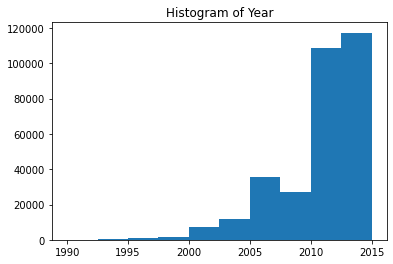

In [358]:
plt.hist(car_df['year'])
plt.title('Histogram of Year')

Most of the cars in the dataset are modern, will need to remove older cars. 

In [359]:
car_df['year'].value_counts()

2012    64523
2013    64449
2014    48107
2011    29043
2008    15603
2010    14975
2007    14682
2006    11533
2009    11279
2005     9169
2004     6528
2003     5356
2015     4774
2002     3562
2001     2333
2000     1402
1999      897
1998      672
1997      489
1996      268
1995      215
1994      139
1993       54
1992       31
1991       23
1990       10
Name: year, dtype: int64

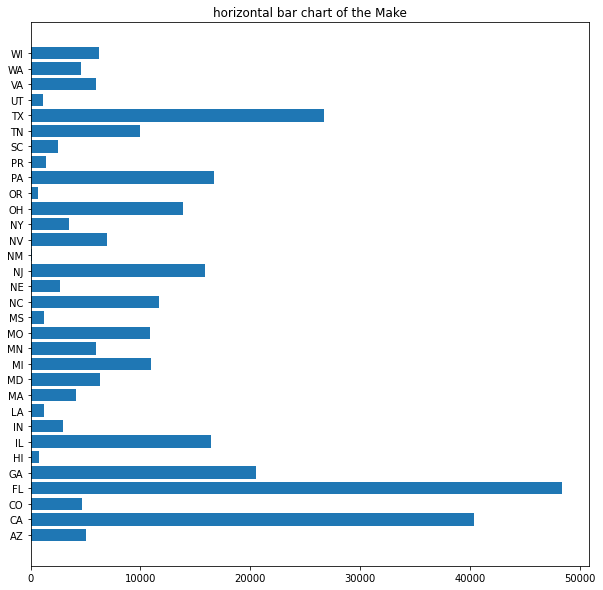

In [360]:
plt.figure(figsize=(10,10))
plt.barh(car_df.groupby("state")["state"].count().index, 
         car_df.groupby("state")["state"].count())
plt.title("horizontal bar chart of the Make")
plt.show()

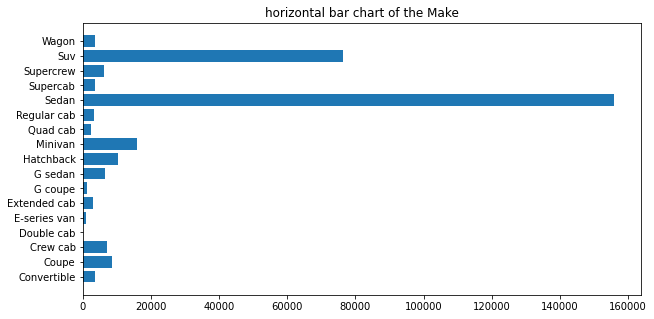

In [361]:
plt.figure(figsize=(10,5))
plt.barh(car_df.groupby("body")["body"].count().index, 
         car_df.groupby("body")["body"].count())
plt.title("horizontal bar chart of the Make")
plt.show()

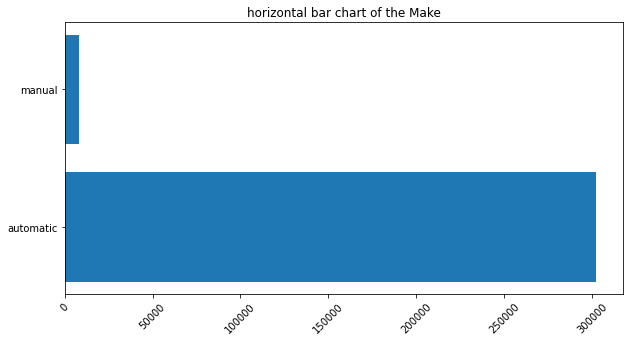

In [362]:
plt.figure(figsize=(10,5))
plt.barh(car_df.groupby("transmission")["transmission"].count().index, 
         car_df.groupby("transmission")["transmission"].count())
plt.title("horizontal bar chart of the Make")
plt.xticks(rotation='45')
plt.show()

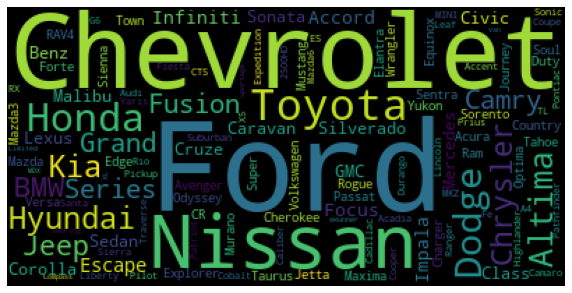

In [363]:
text= ' '.join(car_df['make_model'])
wordcloud2 = WordCloud(collocations=False).generate(text)
# Generate plot
plt.figure(figsize=(10,10))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

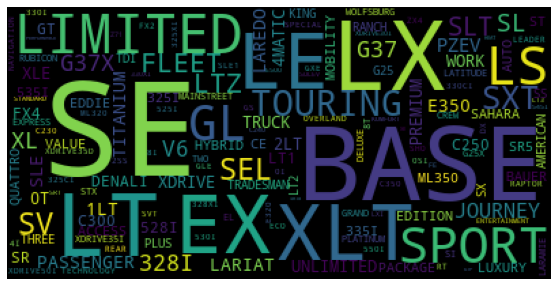

In [364]:
text3 = ' '.join(car_df['trim'])
wordcloud2 = WordCloud(collocations=False).generate(text3)
# Generate plot
plt.figure(figsize=(10,5))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

#### Bivariate Analysis

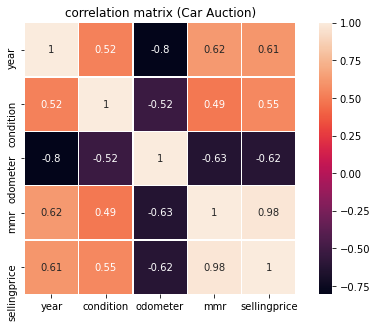

In [365]:
# Continuous/Continuous

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
sns.heatmap(car_df.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Car Auction)")
plt.show()

Most of these have high or moderately high correlation (both positive and negative)

Selling price has high correlation with all

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


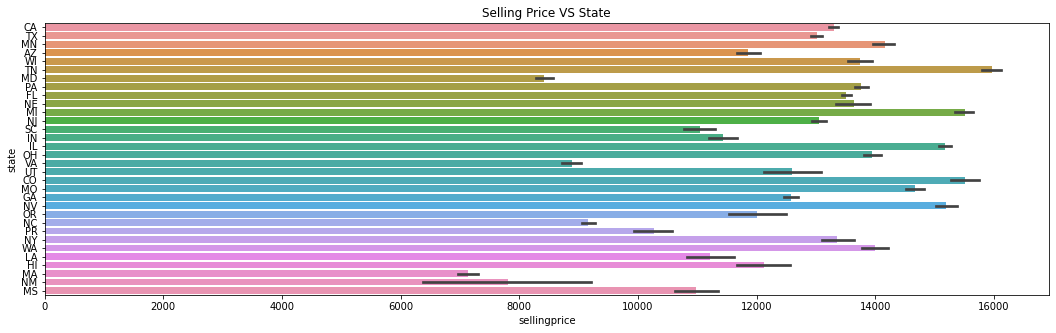

In [366]:
plt.figure(figsize=(18,5))

#plt.subplot(1,3,1)
sns.barplot(car_df["sellingprice"], car_df["state"])
plt.title("Selling Price VS State")
plt.show()

*   New Mexico has high variance 
*   Maryland, Virginia, and Massachussetts have the lowest representation
*   Half the states are not included
*   PR = Puerto Rico

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


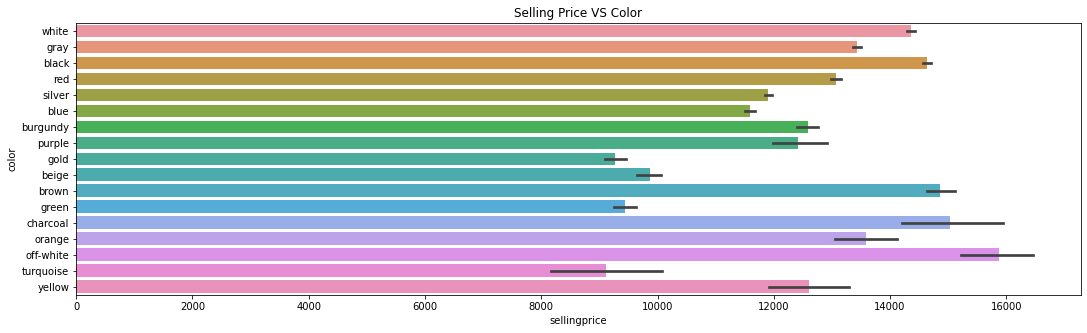

In [367]:
plt.figure(figsize=(18,5))

#plt.subplot(1,3,1)
sns.barplot(car_df["sellingprice"], car_df["color"])
plt.title("Selling Price VS Color")
plt.show()

*   off-white and white may be considered the same for the user?
*   Most of the 'basic' colors are present





## Model Prep

Before we actually implement the model, we need to view the data again and it's meta information. We need to do this to make sure the columns are the right datatypes as well as see if all the data manipulation has been completed

In [368]:
car_df.head()

,year,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,make_model
0,2015,LX,Suv,automatic,CA,5.0,16639.0,white,black,20500,21500,Kia Sorento
1,2015,LX,Suv,automatic,CA,5.0,9393.0,white,beige,20800,21500,Kia Sorento
5,2015,2.5 S,Sedan,automatic,CA,1.0,5554.0,gray,black,15350,10900,Nissan Altima
7,2014,1LT,Sedan,automatic,CA,2.0,28617.0,black,black,11900,9800,Chevrolet Cruze
8,2014,2.0T PREMIUM PLUS QUATTRO,Sedan,automatic,CA,4.2,9557.0,white,black,32100,32250,Audi A4


In [369]:
car_df.isnull().sum()*100/car_df.isnull().count()

year            0.0
trim            0.0
body            0.0
transmission    0.0
state           0.0
condition       0.0
odometer        0.0
color           0.0
interior        0.0
mmr             0.0
sellingprice    0.0
make_model      0.0
dtype: float64

#### Feature Selection

In [370]:
car_df.head()

,year,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,make_model
0,2015,LX,Suv,automatic,CA,5.0,16639.0,white,black,20500,21500,Kia Sorento
1,2015,LX,Suv,automatic,CA,5.0,9393.0,white,beige,20800,21500,Kia Sorento
5,2015,2.5 S,Sedan,automatic,CA,1.0,5554.0,gray,black,15350,10900,Nissan Altima
7,2014,1LT,Sedan,automatic,CA,2.0,28617.0,black,black,11900,9800,Chevrolet Cruze
8,2014,2.0T PREMIUM PLUS QUATTRO,Sedan,automatic,CA,4.2,9557.0,white,black,32100,32250,Audi A4


In [371]:
car_df.head()

,year,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,make_model
0,2015,LX,Suv,automatic,CA,5.0,16639.0,white,black,20500,21500,Kia Sorento
1,2015,LX,Suv,automatic,CA,5.0,9393.0,white,beige,20800,21500,Kia Sorento
5,2015,2.5 S,Sedan,automatic,CA,1.0,5554.0,gray,black,15350,10900,Nissan Altima
7,2014,1LT,Sedan,automatic,CA,2.0,28617.0,black,black,11900,9800,Chevrolet Cruze
8,2014,2.0T PREMIUM PLUS QUATTRO,Sedan,automatic,CA,4.2,9557.0,white,black,32100,32250,Audi A4


In [372]:
car_df.drop(columns=['trim', 'mmr'], inplace=True)

In [373]:
car_df.head()

,year,body,transmission,state,condition,odometer,color,interior,sellingprice,make_model
0,2015,Suv,automatic,CA,5.0,16639.0,white,black,21500,Kia Sorento
1,2015,Suv,automatic,CA,5.0,9393.0,white,beige,21500,Kia Sorento
5,2015,Sedan,automatic,CA,1.0,5554.0,gray,black,10900,Nissan Altima
7,2014,Sedan,automatic,CA,2.0,28617.0,black,black,9800,Chevrolet Cruze
8,2014,Sedan,automatic,CA,4.2,9557.0,white,black,32250,Audi A4


I dropped the 'trim' variable since there are too many categories. 

I also dropped the 'mmr' variable since it was highly correlated with the 'sellingprice' variable

In [374]:
car_df.to_csv(r'CarSalesFinal4.csv', index = False)

In [375]:
car_df.head()

,year,body,transmission,state,condition,odometer,color,interior,sellingprice,make_model
0,2015,Suv,automatic,CA,5.0,16639.0,white,black,21500,Kia Sorento
1,2015,Suv,automatic,CA,5.0,9393.0,white,beige,21500,Kia Sorento
5,2015,Sedan,automatic,CA,1.0,5554.0,gray,black,10900,Nissan Altima
7,2014,Sedan,automatic,CA,2.0,28617.0,black,black,9800,Chevrolet Cruze
8,2014,Sedan,automatic,CA,4.2,9557.0,white,black,32250,Audi A4


#### One-Hot Encoding

We need to one-hot encode (string->numeric) our qualitative variables since algorithms can't work with string types.

In [376]:
car_df.head()

,year,body,transmission,state,condition,odometer,color,interior,sellingprice,make_model
0,2015,Suv,automatic,CA,5.0,16639.0,white,black,21500,Kia Sorento
1,2015,Suv,automatic,CA,5.0,9393.0,white,beige,21500,Kia Sorento
5,2015,Sedan,automatic,CA,1.0,5554.0,gray,black,10900,Nissan Altima
7,2014,Sedan,automatic,CA,2.0,28617.0,black,black,9800,Chevrolet Cruze
8,2014,Sedan,automatic,CA,4.2,9557.0,white,black,32250,Audi A4


In [377]:
car_df = pd.concat([car_df, pd.get_dummies(car_df[['make_model', 'body', 'transmission',	'state',	'color',	'interior']], drop_first=True)], axis=1)
car_df.drop(columns=['make_model', 'body', 'transmission',	'state',	'color',	'interior'], axis=1, inplace=True)

In [378]:
X.head()

,year,body,transmission,state,condition,odometer,color,interior,make_model
0,2015,Suv,automatic,CA,5.0,16639.0,white,black,Kia Sorento
1,2015,Suv,automatic,CA,5.0,9393.0,white,beige,Kia Sorento
5,2015,Sedan,automatic,CA,1.0,5554.0,gray,black,Nissan Altima
7,2014,Sedan,automatic,CA,2.0,28617.0,black,black,Chevrolet Cruze
8,2014,Sedan,automatic,CA,4.2,9557.0,white,black,Audi A4


### Train and Test

Next we need to separate the variables into X (features) and Y (target).

In this case, 'sellingprice' will be the target

In [379]:
from sklearn.model_selection import train_test_split, cross_val_score

X = car_df.drop(columns='sellingprice', axis=1)
y = car_df['sellingprice']


In [380]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2)

In [ ]:
for i in X.columns:
  print(i)

In [382]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (248092, 180)
Number transactions y_train dataset:  (248092,)
Number transactions X_test dataset:  (62024, 180)
Number transactions y_test dataset:  (62024,)


# Model

For now I have a simple model but will need to tune the hyperparameters. GridSearch will be useful for this, however, will take some time to compute.

In [383]:
rf = RandomForestRegressor(n_estimators=100, max_depth=8)
model = rf.fit(X_train, y_train)

Saved the model in a pickle file so I can use it in my CarApp.py file

In [384]:
import pickle
pickle.dump(model, open('CarAuctionFinal3.pkl', 'wb'))

### Score

In [385]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.7267220483490002
0.723655467784577
